## Introduction<a id='introduction'></a>

**Purpose:**

Clean and explore dataset on allogeneic HCT.

**Context:**

Hematopoietic stem cells, which reside in the bone marrow, are responsible for generating all blood cells, including red blood cells, platelet-producing cells, and immune system cells such as T cells, B cells, neutrophils, and natural killer cells. Allogeneic hematopoietic cell transplantation (HCT) can replace an individual's faulty hematopoietic stem cells with functional ones restoring healthy immune system function. 

Improving survival predictions for allogeneic HCT patients is a vital healthcare challenge. Current predictive models often fall short in addressing disparities related to socioeconomic status, race, and geography. Addressing these gaps is crucial for enhancing patient care, optimizing resource utilization, and rebuilding trust in the healthcare system.

The goal of the project is to predict an individual's risk score. (Target variable is ```efs```)

**Data:**

Project and data comes from [Kaggle](https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions/overview)

**Outcomes from this notebook (Data Wrangling):**
- Converted nans and nan-like values to 'NOT TESTED'
- graft_type and prod_type appear to be redundant, however 5% of values are mismatched. Keeping graft_type and removing prod_type
- Data confirms prognostic factors identified from UpToDate
    - Younger age trends with improved outcomes
        - Consider stratifying age by Infant, Pediatric, Adult (19-40), Adult (41-64), Senior (65+)
    - Increased comorbidities worsens outcome
        - Can stratify by aggregate comorbidity score of [0, 1-2, 3+] or [0,1,2,3,4+]
    - DRI score roughly predicts EFS
    - Cyto score does not predict EFS
    - karnofsky performance score does predict EFS with higher scores leading to improved outcomes. Note: KPS is designed for patients age 16+
    - cmv status does predict EFS with -/+ at most risk and +/- at the least risk
    - prior solid tumor does worsen outcome

## Contents<a id='contents'></a>
* [Introduction](#introduction)
* [Contents](#contents)
* [Objectives](#objectives)
* [Cleaning Data](#cleaning_data)
* [Exploring Data](#exploring_data)
    * [Trends by Age](#trends_by_age)
    * [Trends by Sorror Comorbidity](#trends_by_sorror_comorbidity)
    * [Trends by DRI Score](#trends_by_dri_score)
    * [Trends by Cyto Score](#trends_by_cyto_score)
    * [Trends by Karnofsky Score](#trends_by_karnofsky_score)
    * [Trends by CMV Status](#trends_by_cmv_status)
    * [Trends by Prior Solid Tumor](#trends_by_prior_solid_tumor)
* [Saving Data](#saving_data)
* [Summary](#summary)    

## Objectives<a id='objectives'></a>
1. Remove corrupt/faulty data (clean data)
2. Remove or fill nans (impute data)
3. Explore data for implicit patterns
4. Figure out how to process data for training
    - 1-hot encoding
    - scaling
    - dimensionality reduction
    - discretize age and other continuous data

## Cleaning Data<a id='cleaning_data'></a>
**Results:**
- Converting all nans to 'Not Tested' and converting all 'Not done'-type entries to 'Not tested' for consistency
- cyto_score (72.0%), tce_imm_match (61.3%), cyto_score_detail (58.6%), mrd_hct (42.3%), tce_match (34%), tce_div_match (60.4%) all missing large amounts of data (% show non-null)
- Will impute float/int values using KNN in later stage
- graft_type and prod_type are redundant. Want to remove one but there are inconsistencies for 5% of records. Not sure which to keep, maybe graft type?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.rcParams.update({'font.size': 12, 'figure.figsize':(4,3)})

In [2]:
data = pd.read_csv('../data/raw/train.csv')
data_dictionary = pd.read_csv('../data/raw/data_dictionary.csv')

In [3]:
data.head(3)

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793


In [4]:
data.notnull().sum()/data.shape[0]

ID                        1.000000
dri_score                 0.994653
psych_disturb             0.928403
cyto_score                0.719861
diabetes                  0.926424
hla_match_c_high          0.839583
hla_high_res_8            0.797604
tbi_status                1.000000
arrhythmia                0.923542
hla_low_res_6             0.886458
graft_type                1.000000
vent_hist                 0.991007
renal_issue               0.933507
pulm_severe               0.925868
prim_disease_hct          1.000000
hla_high_res_6            0.816528
cmv_status                0.977986
hla_high_res_10           0.751285
hla_match_dqb1_high       0.819479
tce_imm_match             0.613437
hla_nmdp_6                0.854271
hla_match_c_low           0.902778
rituximab                 0.925417
hla_match_drb1_low        0.908229
hla_match_dqb1_low        0.854375
prod_type                 1.000000
cyto_score_detail         0.586007
conditioning_intensity    0.833715
ethnicity           

<Axes: >

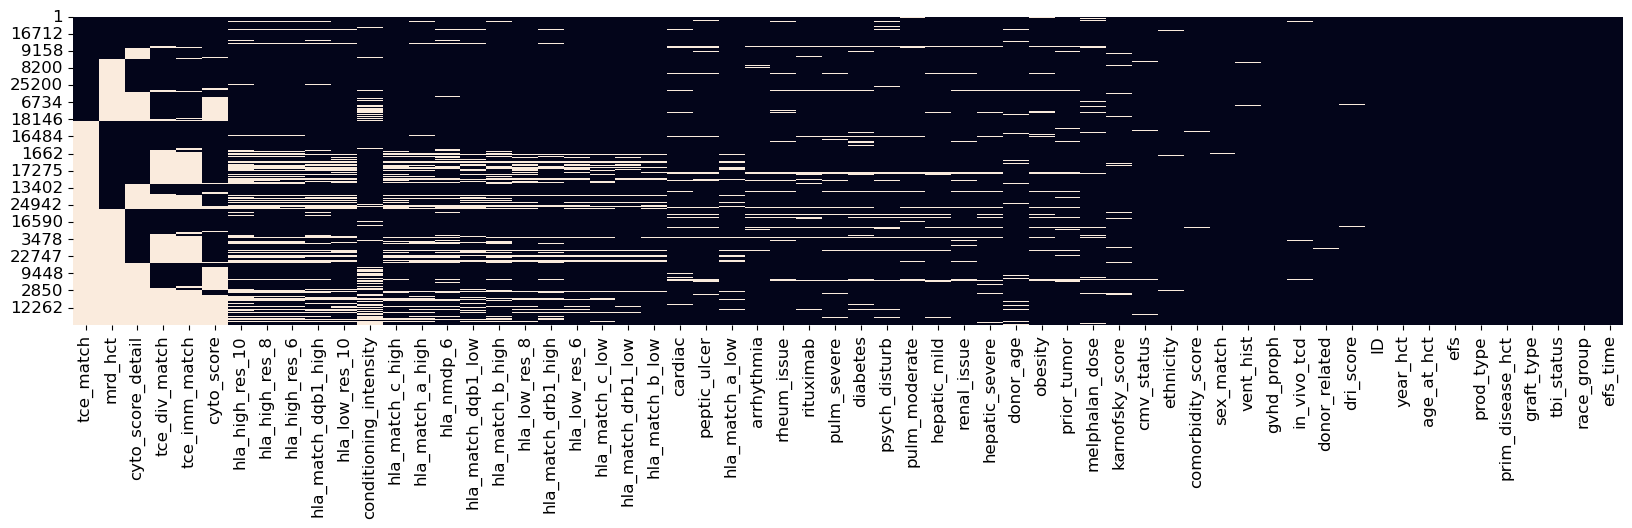

In [5]:
cols=list(data.notnull().sum().sort_values().index)
plt.figure(figsize=(20,4))
sns.heatmap(data[cols].isnull().sort_values(by=cols[:6]), cbar=False)

In [6]:
object_cols = list(data.columns[data.dtypes.values == 'O'])

In [14]:
data['graft_type'].value_counts()

Peripheral blood    20546
Bone marrow          8254
Name: graft_type, dtype: int64

In [15]:
data['prod_type'].value_counts()

PB    20381
BM     8419
Name: prod_type, dtype: int64

In [23]:
mapper = {'Bone marrow': 'BM', 'Peripheral blood':'PB'}
graft_data = list(map(lambda x: mapper[x], data['graft_type']))

In [30]:
data[graft_data != data['prod_type']][['graft_type', 'prod_type']].value_counts()

graft_type        prod_type
Peripheral blood  BM           875
Bone marrow       PB           710
dtype: int64

In [7]:
my_dict = {}
for i in object_cols:
    my_dict[i] = list(data[i].unique())

In [8]:
my_dict

{'dri_score': ['N/A - non-malignant indication',
  'Intermediate',
  'High',
  'Low',
  'N/A - disease not classifiable',
  'N/A - pediatric',
  'TBD cytogenetics',
  'Intermediate - TED AML case <missing cytogenetics',
  nan,
  'High - TED AML case <missing cytogenetics',
  'Very high',
  'Missing disease status'],
 'psych_disturb': ['No', 'Not done', 'Yes', nan],
 'cyto_score': [nan,
  'Intermediate',
  'Poor',
  'Other',
  'Favorable',
  'TBD',
  'Normal',
  'Not tested'],
 'diabetes': ['No', 'Yes', 'Not done', nan],
 'tbi_status': ['No TBI',
  'TBI +- Other, >cGy',
  'TBI + Cy +- Other',
  'TBI +- Other, <=cGy',
  'TBI +- Other, unknown dose',
  'TBI +- Other, -cGy, fractionated',
  'TBI +- Other, -cGy, single',
  'TBI +- Other, -cGy, unknown dose'],
 'arrhythmia': ['No', 'Yes', nan, 'Not done'],
 'graft_type': ['Bone marrow', 'Peripheral blood'],
 'vent_hist': ['No', 'Yes', nan],
 'renal_issue': ['No', nan, 'Yes', 'Not done'],
 'pulm_severe': ['No', 'Yes', nan, 'Not done'],
 'prim

In [42]:
data[object_cols] = data[object_cols].fillna('NOT TESTED')
data[object_cols] = data[object_cols].replace('Not done|Not tested|TBD|N/A, F\(pre-TED\) not submitted', 'NOT TESTED', regex=True)

In [43]:
object_cols = list(data.columns[data.dtypes.values == 'O'])
my_dict = {}
for i in object_cols:
    my_dict[i] = list(data[i].unique())
my_dict

{'dri_score': ['N/A - non-malignant indication',
  'Intermediate',
  'High',
  'Low',
  'N/A - disease not classifiable',
  'N/A - pediatric',
  'NOT TESTED cytogenetics',
  'Intermediate - TED AML case <missing cytogenetics',
  'NOT TESTED',
  'High - TED AML case <missing cytogenetics',
  'Very high',
  'Missing disease status'],
 'psych_disturb': ['No', 'NOT TESTED', 'Yes'],
 'cyto_score': ['NOT TESTED',
  'Intermediate',
  'Poor',
  'Other',
  'Favorable',
  'Normal'],
 'diabetes': ['No', 'Yes', 'NOT TESTED'],
 'tbi_status': ['No TBI',
  'TBI +- Other, >cGy',
  'TBI + Cy +- Other',
  'TBI +- Other, <=cGy',
  'TBI +- Other, unknown dose',
  'TBI +- Other, -cGy, fractionated',
  'TBI +- Other, -cGy, single',
  'TBI +- Other, -cGy, unknown dose'],
 'arrhythmia': ['No', 'Yes', 'NOT TESTED'],
 'graft_type': ['Bone marrow', 'Peripheral blood'],
 'vent_hist': ['No', 'Yes', 'NOT TESTED'],
 'renal_issue': ['No', 'NOT TESTED', 'Yes'],
 'pulm_severe': ['No', 'Yes', 'NOT TESTED'],
 'prim_disea

<Axes: >

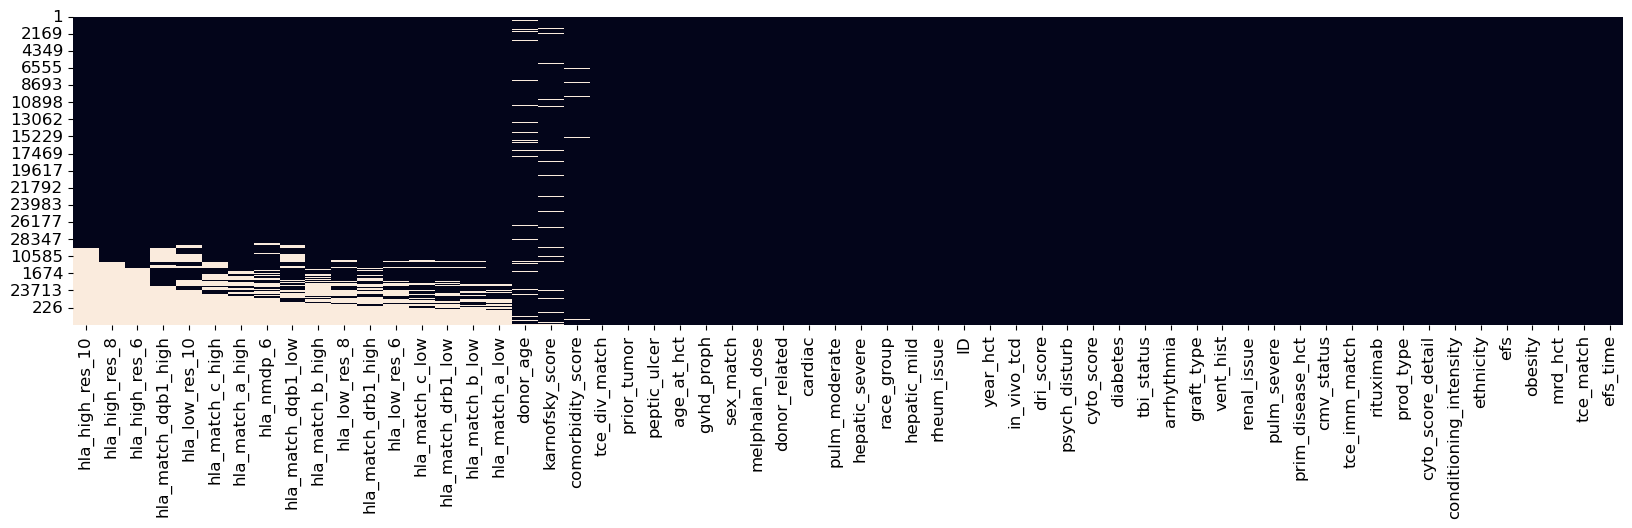

In [33]:
# after filling nans with 'NOT TESTED' and replacing 'Not done' with 'NOT TESTED'
cols=list(data.notnull().sum().sort_values().index)
plt.figure(figsize=(20,4))
sns.heatmap(data[cols].isnull().sort_values(by=cols[:17]), cbar=False)

## Exploring Data<a id='exploring_data'></a>

**Results:**

After filling nans with NOT TESTED and converting similar values to NOT TESTED, ~25% of hla data remains missing. Consider imputing with KNN.

Data confirms prognostic factors identified from UpToDate.
- Younger age trends with improved outcomes
    - Consider stratifying age by Infant, Pediatric, Adult (19-40), Adult (41-64), Senior (65+)
- Increased comorbidities worsens outcome
    - Can stratify by aggregate comorbidity score of [0, 1-2, 3+] or [0,1,2,3,4+]
- DRI score roughly predicts EFS
- Cyto score does not predict EFS
- karnofsky performance score does predict EFS with higher scores leading to improved outcomes. Note: KPS is designed for patients age 16+
- cmv status does predict EFS with -/+ at most risk and +/- at the least risk
- prior solid tumor does worsen outcome

**Prognostic Instruments:** \
Successes:
- Most effectively stratify risk among patient populations for survival outcomes

Short comings:
- No single prognostic instrument proven superior
- Suboptimal accuracy in predicting individual patient outcome
- Generally not effective in predicting who will develop chronic graft-versus-host disease

**Summary of prognostic instruments:**

- Sorror et al. developed hematopoietic cell transplant specific comorbidity index (**HCT-CI**) which predicts survival following allogeneic HCT in patients with hematologic malignancies
    - **Key insight:** post-HCT survival linked to comorbidities and is used as standard practice for prognosis
    - **Links:** https://www.mdcalc.com/calc/3980/hematopoietic-cell-transplantation-specific-comorbidity-index-hct-ci https://pubmed.ncbi.nlm.nih.gov/25862591/
    - HCT-CI widely used and widely validated
    - <mark>Arrhythmia, cardiac disease, inflammatory bowl movement (crohn disease or ulcerative colitis), diabetes, cerebrovascular disease, psychiatric disturbance, hepatic dysfunction, obesity (BMI > 35 kg/m2), rheumatologic disease, peptic ulcer, renal dysfunction, pulmonary dysfunction, prior solid tumor</mark> all contribute to HCT-CI. Included in dataset as ```comorbidity_score```
        - History of arrhythmia: (atrial fibrillation or flutter, sick sinus syndrome, or ventricular arrhythmias) is given 1 point
        - Cardiac disease: (CAD, CHF, MI, or EF <= 50%) is given 1 point and heart valve diease (except mitral valve prolapse) is given 3 points
        - Inflammatory bowl disease: (Crohn diease or ulcerative colitis) is given 1 point
        - Diabetes: Treated with insulin or oral hypoglcemics is given 1 point
        - Cerebrovascular diease: (CVA or TIA) is given 1 point
        - Psychiatric disturbance: (depression or anxiety requiring psychiatric consult or treatment) is given 1 point
        - Hepatic dysfunction: Chronic hepatitis (bilirubin > ULN to 1.5xULN, or AST/ALT > ULN to 2.5xULN) is given 1 point and liver cirrhosis is given 3 points
        - Obesity: BMI >= 35 kg/m2 is given 1 point
        - Infection: Any requiring continuation of antimicrobial treatment is given 1 point
        - Rheamatologic diease:(SLE, RA, polymyositis, mixed CTD, or polymyalgia rheumatica) is given 2 points
        - Peptic ulcer: any requiring treatment is given 2 points
        - Renal dysfunction: (Serum creatinine > 2 mg/dL, on dialysis, or prior renal transplant) is given 2 points
        - Pulmonary dysction: (DLco and/FEV 66%-80% or dyspnea on slight activity) is given 2 points and (DLco and/or FEV <= 65% or dyspnea at rest or requiring oxygen) is given 3 points
        - Prior solid tumor: if at any point in patient history, then given 3 points
        - Score can range from 0-29. Binning varies either [0, 1-2, 3+] or [0, 1, 2, 3, 4]
- Gratwohl et al. developed European Bone Marrow Transplantation (**EBMT**) risk score to predict survival following allogeneic HCT in patients with chronic myeloid leukemia
    - **Key insight:** post-HCT survival can be predicted using very few features
    - **Links:** https://pubmed.ncbi.nlm.nih.gov/9798583/ https://www.uptodate.com/contents/allogeneic-hematopoietic-cell-transplantation-indications-eligibility-and-prognosis https://pubmed.ncbi.nlm.nih.gov/15147377/
    - EBMT widely used
    - Also validated for patients with acute leukemias (acute myeloud leukemia and acute lymphoblastic leukemia) and various hematologic disorders (CML, AML, ALL, myelodysplatic syndromes/neoplasms, multiple myeloma, non-Hodgkin lymphoma, aplastic anemia)
    - <mark>Age, disease stage, time from diagnosis, donor type, and donor-recipient sex match</mark> contribute to EBMT
        - Age: 20-40 years old and > 40 years old given score of 1 and 2, respectively
        - Disease stage: accelerated phase and blast crisis or >= 2nd chronic phase given scores of 1 and 2, respectively
        - Time to HCT from diagnosis: > 12 months given score of 1
        - Donor type: HLA-matched unrelated donor given score of 1
        - Donor-recipient sex matching: femal donor and male recipient given score of 1
        - Scoring ranges from 0 to 7 with 5-year OS of 72%, 70%, 62%, 48%, 40%, 18%, 22%, and -- (not enough patients with total score of 7 to adequately determing 5-yr OS)
- Barba et al. developed **Comorbidity-EBMT** index to predict survival following allogeneic HCT with reduced-toxicity conditioning
    - **Key insight:** HCT-CI combined with EBMT provides additional granularity, potentially increasing predictive power
    - **Link:** https://www.astctjournal.org/article/S1083-8791(13)00459-X/fulltext
    - Applies comorbidity screening of HCT-CI to EBMT. Tested on population size of n=442
    - HCT-CI and EBMT calculated as originally defined
        - Scores binned into 6 categories according to HCT-CI (0, 1-2, 3+) and EBMT (0-3, 4-7)
        - HCT-CI more strongly trended with survival than EBMT
- 
    - **Key insight:** CIBMTR score stratifies patients into low, intermediate, and high risk following autologous HCT for multiple myeloma
    - **Link:** https://ashpublications.org/blood/article/140/Supplement%201/7217/493111/Validation-of-the-CIBMTR-Scoring-System-in
- Brazaukas et al. developed a risk to predict event-free survival after allogeneic hematopoietic cell transplantation for sickle cell disease.
    - **Key insight:** Patient age, degree of HLA matching between donor and recipient, and whether donor is related to the recipient are important factors for predicting EFS in patients with sickle cell disease
    - **Link:** https://pubmed.ncbi.nlm.nih.gov/32518950/
    - Trained on population size of n=1425.
    - Risk factors were identified and validated via Cox regression models
    - <mark>Age</mark> at transplantation and <mark>donor type</mark> were predictive for EFS
        - Patients age 12 and younger with an HLA-matched sibling donor were at lowest risk with a 3-year EFS of 92%
        - Patients age 13 and older with an HLA-matched sibling donor or patients age 12 and youger with HLA-matched unrelated donor were at intermediate risk with a 3-year EFS of 87%
        - All other groups were at the highest risk with a 3-year EFS of 57%
        - Note: data does include patient age, whether donor is HLA-matched, and whether donor is related to the patient
- Vasbinder et al. developed a risk score for cardiovascular events post-HCT, either autologous (from same patient) or allogeneic HCT, for patients with malignant or benign bone marrow disorders
    - **Key insight:** Risk of cardiovascular event following a HCT can be identified through age, transplant type, race, coronary artery disease, heart failure, peripheral artery disease, creatinine, triglycerides, and prior anthracycline dose
    - **Link:** https://www.ahajournals.org/doi/10.1161/JAHA.123.033599
    - Trained on population size of n=2435, obtained from CARE-BMT (Cardiovascular Registry in Bone Marrow Transplantation)
        - All patients underwent autologous or allogeneic HCT for malignant or benign bone marrow disorders at the University of Michigan Health System and Rush University Medical Center between Jan. 2008 and Dec. 2019
    - Post-HCT cardiovascular events defined as composite of cardiovascular death, myocardial infarcation, heart failure, stroke, atrial fibrillation or flutter, and sustained ventricular tachycardia
    - Risk factors and scores identified from Cox proportional hazards modeling
    - Aggregate risk score grouped as low, intermediate, and high risk with 5-year cumulative incidence of cardiovascular events being 4.0%, 10.3%, and 22.4%, respectively
    - <mark>Age, transplant type, race, coronary artery disease, heart failure, peripheral artery disease, creatinine, triglycerides, and prior anthracycline dose</mark> contribute to risk score
        - Ages 50-54, 55-64, and >=65 are given a score of 1, 2, and 3, respectively
        - Black patients are given a score of 1
        - Allogeneic transplant is given score of 2
        - Anthracycline prior dose >= 250 mg/m2 is given a score of 2
        - Coronary artery disease is given a score of 1
        - History of heart failure is given a score of 1
        - Peripheral artery disease is given a score of 1
        - Creatinine > 1 mg/dL if given a score of 1
        - Triglycerides > 150 mg/dL is given a score of 1
        - Aggregate scores of <= 1, 2-4, and >=5 points are stratified into low, intermediate, and high risk


<Axes: >

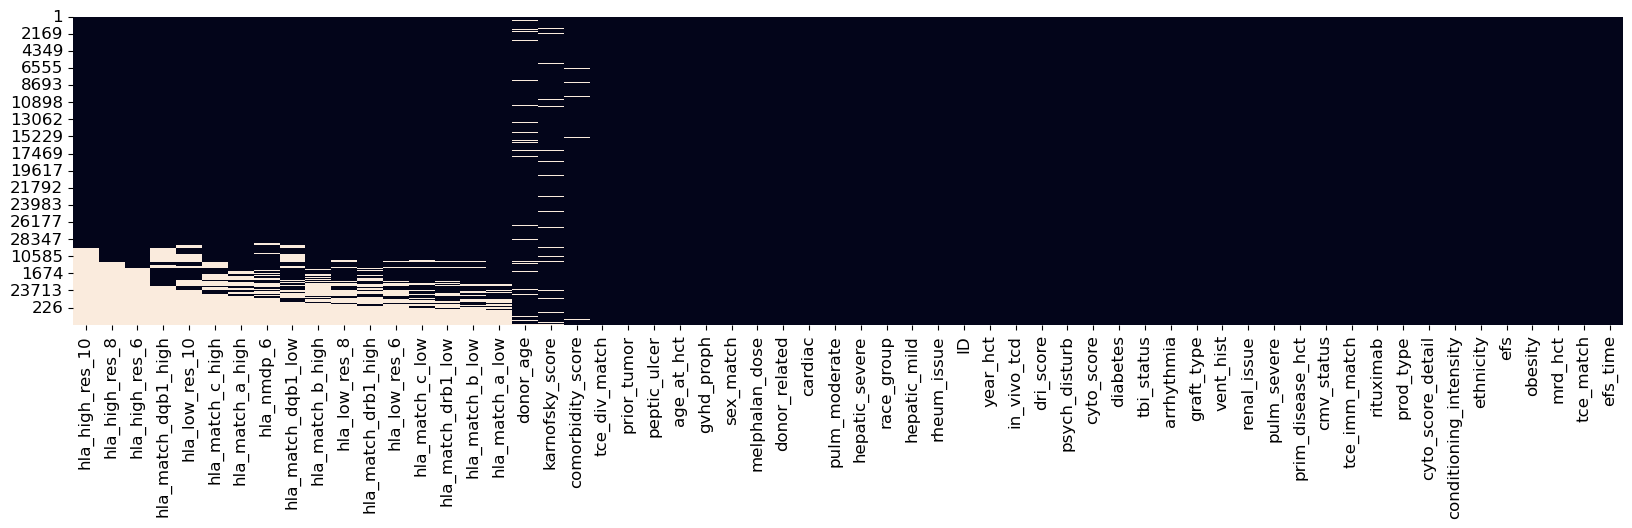

In [22]:
# after filling nans with 'NOT TESTED' and replacing 'Not done' with 'NOT TESTED'
cols=list(data.notnull().sum().sort_values().index)
plt.figure(figsize=(20,4))
sns.heatmap(data[cols].isnull().sort_values(by=cols[:17]), cbar=False)

### Trends by Age<a id='trends_by_age'></a>

In [91]:
def calc_efs_stats(df):
    my_df = {}
    my_df['Count'] = int(df.shape[0])
    my_df['Avg efs'] = df['efs'].mean().round(2)
    my_df['Sem efs'] = round(df['efs'].sem(), 2)
    my_df['Avg efs_time | efs=0'] = df[df['efs'] == 0]['efs_time'].mean().round(2)
    my_df['Std efs_time | efs=0'] = round(df[df['efs'] == 0]['efs_time'].std(), 2)
    my_df['Avg efs_time | efs=1'] = df[df['efs'] == 1]['efs_time'].mean().round(2)
    my_df['Std efs_time | efs=1'] = round(df[df['efs'] == 1]['efs_time'].std(), 2)
    return my_df

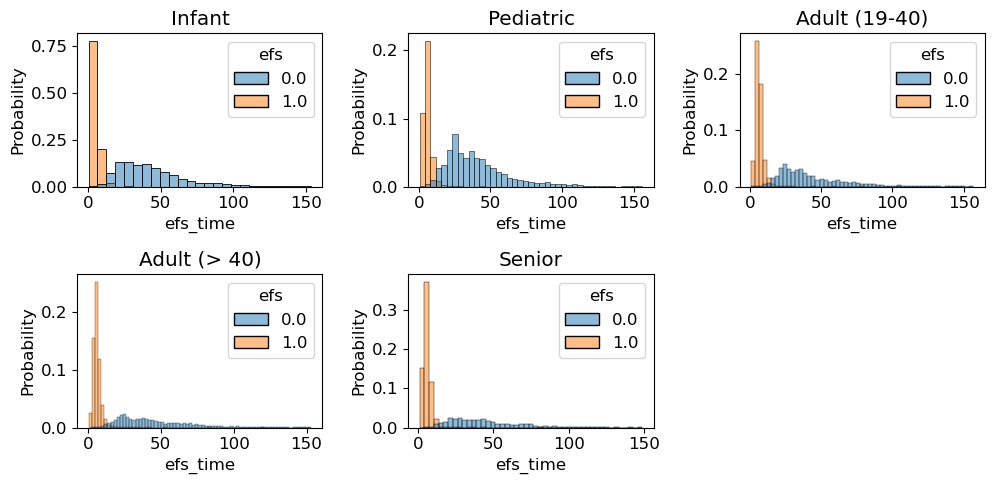

In [66]:
plt.figure(figsize=(10,5))
plt.subplot(2,3,1)
sns.histplot(data=data[data['age_at_hct'] < 1], x='efs_time', hue='efs', stat='probability', common_norm=False)
plt.title('Infant')
plt.subplot(2,3,2)
sns.histplot(data=data[(data['age_at_hct'] > 1) & (data['age_at_hct'] < 19)], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('Pediatric')
plt.subplot(2,3,3)
sns.histplot(data=data[(data['age_at_hct'] > 19) & (data['age_at_hct'] < 41)], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('Adult (19-40)')
plt.subplot(2,3,4)
sns.histplot(data=data[(data['age_at_hct'] > 41) & (data['age_at_hct'] < 65)], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('Adult (> 40)')
plt.subplot(2,3,5)
sns.histplot(data=data[data['age_at_hct'] > 65], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('Senior')
plt.tight_layout()

In [92]:
my_df = {}
my_df['Infant'] = calc_efs_stats(data[data['age_at_hct'] < 1])
my_df['Pediatric'] = calc_efs_stats(data[(data['age_at_hct'] > 1) & (data['age_at_hct'] < 19)])
my_df['Adult (19-40)'] = calc_efs_stats(data[(data['age_at_hct'] > 19) & (data['age_at_hct'] < 41)])
my_df['Adult (>40)'] = calc_efs_stats(data[(data['age_at_hct'] > 41) & (data['age_at_hct'] < 65)])
my_df['Senior'] = calc_efs_stats(data[data['age_at_hct'] > 65])
pd.DataFrame.from_dict(my_df, orient='columns')

,Infant,Pediatric,Adult (19-40),Adult (>40),Senior
Count,1455.00,5618.00,7324.00,11943.00,2459.00
Avg efs,0.24,0.38,0.56,0.61,0.67
Sem efs,0.01,0.01,0.01,0.00,0.01
Avg efs_time | efs=0,43.78,40.80,42.93,44.67,44.16
Std efs_time | efs=0,23.84,22.82,24.30,25.31,23.79
Avg efs_time | efs=1,5.08,5.91,6.55,6.30,6.02
Std efs_time | efs=1,2.91,2.99,3.62,3.33,3.54


### Trends by Sorror Comorbidity<a id='trends_by_sorror_comorbidity'></a>

<Axes: xlabel='comorbidity_score', ylabel='Count'>

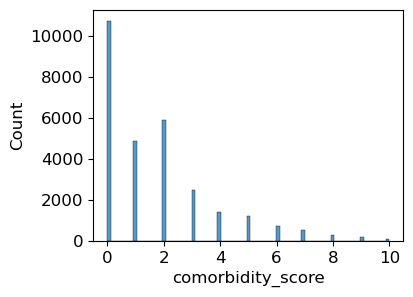

In [94]:
sns.histplot(data=data, x='comorbidity_score')

In [ ]:
# comorbidity bins are either [0, 1-2, 3+] or [0, 1, 2, 3, 4+]

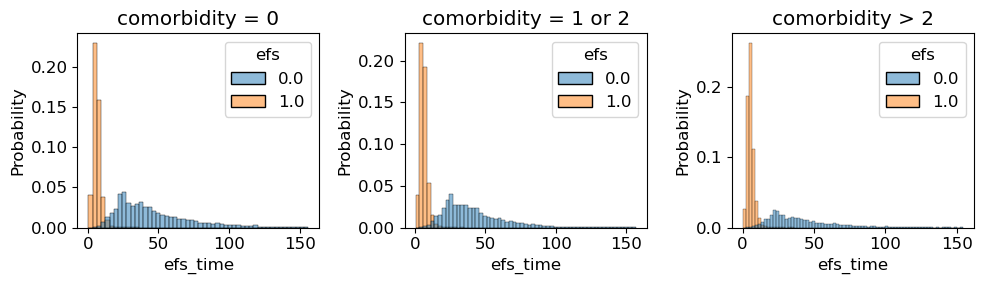

In [96]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
sns.histplot(data=data[data['comorbidity_score'] == 0], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('comorbidity = 0')
plt.subplot(1,3,2)
sns.histplot(data=data[(data['comorbidity_score'] == 1) | (data['comorbidity_score'] == 2)], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('comorbidity = 1 or 2')
plt.subplot(1,3,3)
sns.histplot(data=data[data['comorbidity_score'] > 2], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('comorbidity > 2')
plt.tight_layout()

In [100]:
my_df = {}
my_df['Comorbidity = 0'] = calc_efs_stats(data[data['comorbidity_score'] == 0])
my_df['Comorbidity = 1 or 2'] = calc_efs_stats(data[(data['comorbidity_score'] == 1) | (data['comorbidity_score'] == 2)])
my_df['Comorbidity > 2'] = calc_efs_stats(data[data['comorbidity_score'] > 2])
pd.DataFrame.from_dict(my_df, orient='columns')

,Comorbidity = 0,Comorbidity = 1 or 2,Comorbidity > 2
Count,10738.00,10751.00,6834.00
Avg efs,0.48,0.53,0.65
Sem efs,0.00,0.00,0.01
Avg efs_time | efs=0,45.31,41.84,40.83
Std efs_time | efs=0,25.60,22.63,23.44
Avg efs_time | efs=1,6.47,6.23,5.71
Std efs_time | efs=1,2.73,2.57,2.52


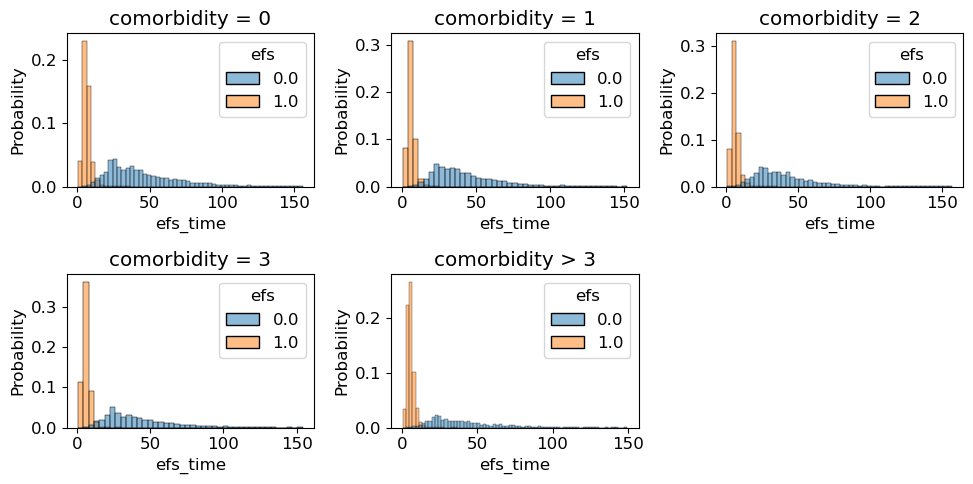

In [97]:
plt.figure(figsize=(10,5))
plt.subplot(2,3,1)
sns.histplot(data=data[data['comorbidity_score'] == 0], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('comorbidity = 0')
plt.subplot(2,3,2)
sns.histplot(data=data[data['comorbidity_score'] == 1], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('comorbidity = 1')
plt.subplot(2,3,3)
sns.histplot(data=data[data['comorbidity_score'] == 2], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('comorbidity = 2')
plt.subplot(2,3,4)
sns.histplot(data=data[data['comorbidity_score'] == 3], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('comorbidity = 3')
plt.subplot(2,3,5)
sns.histplot(data=data[data['comorbidity_score'] > 3], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('comorbidity > 3')
plt.tight_layout()

In [101]:
my_df = {}
my_df['Comorbidity = 0'] = calc_efs_stats(data[data['comorbidity_score'] == 0])
my_df['Comorbidity = 1'] = calc_efs_stats(data[data['comorbidity_score'] == 1])
my_df['Comorbidity = 2'] = calc_efs_stats(data[data['comorbidity_score'] == 2])
my_df['Comorbidity = 3'] = calc_efs_stats(data[data['comorbidity_score'] == 3])
my_df['Comorbidity > 3'] = calc_efs_stats(data[data['comorbidity_score'] > 3])
pd.DataFrame.from_dict(my_df, orient='columns')

,Comorbidity = 0,Comorbidity = 1,Comorbidity = 2,Comorbidity = 3,Comorbidity > 3
Count,10738.00,4852.00,5899.00,2460.00,4374.00
Avg efs,0.48,0.51,0.54,0.58,0.68
Sem efs,0.00,0.01,0.01,0.01,0.01
Avg efs_time | efs=0,45.31,42.42,41.34,41.95,40.02
Std efs_time | efs=0,25.60,22.56,22.69,23.86,23.10
Avg efs_time | efs=1,6.47,6.33,6.16,6.07,5.54
Std efs_time | efs=1,2.73,2.55,2.58,2.45,2.53


### Trends by DRI Score<a id='trends_by_dri_score'></a>

In [102]:
data['dri_score'].value_counts()

Intermediate                                         10436
N/A - pediatric                                       4779
High                                                  4701
N/A - non-malignant indication                        2427
TBD cytogenetics                                      2003
Low                                                   1926
High - TED AML case <missing cytogenetics             1414
Intermediate - TED AML case <missing cytogenetics      481
N/A - disease not classifiable                         272
Very high                                              198
NOT TESTED                                             154
Missing disease status                                   9
Name: dri_score, dtype: int64

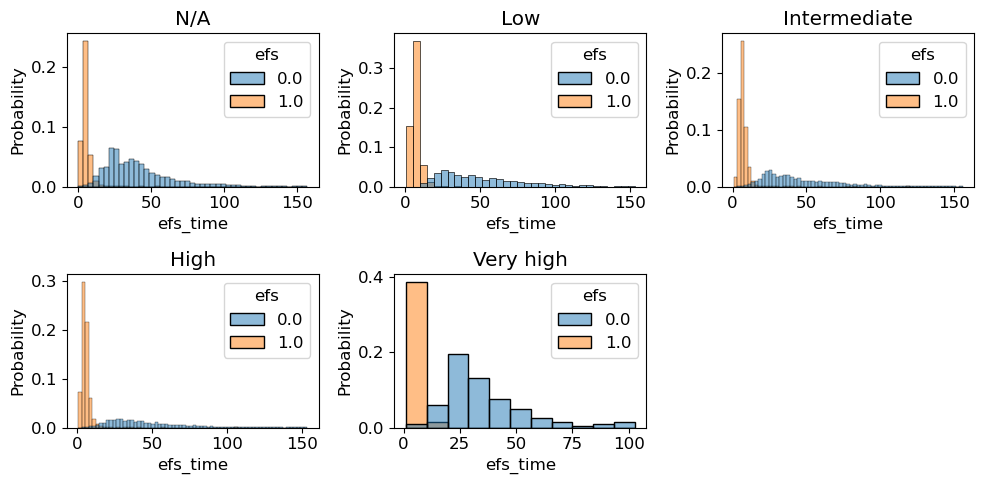

In [109]:
plt.figure(figsize=(10,5))
plt.subplot(2,3,1)
sns.histplot(data=data[data['dri_score'].str.match('N/A')], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('N/A')
plt.subplot(2,3,2)
sns.histplot(data=data[data['dri_score'] == 'Low'], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('Low')
plt.subplot(2,3,3)
sns.histplot(data=data[data['dri_score'].str.match('Intermediate')], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('Intermediate')
plt.subplot(2,3,4)
sns.histplot(data=data[data['dri_score'].str.match('High')], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('High')
plt.subplot(2,3,5)
sns.histplot(data=data[data['dri_score'].str.match('Very high')], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('Very high')
plt.tight_layout()

In [110]:
my_df = {}
my_df['dri score N/A'] = calc_efs_stats(data[data['dri_score'].str.match('N/A')])
my_df['dri score Low'] = calc_efs_stats(data[data['dri_score'].str.match('Low')])
my_df['dri score Intermediate'] = calc_efs_stats(data[data['dri_score'].str.match('Intermediate')])
my_df['dri score High'] = calc_efs_stats(data[data['dri_score'].str.match('High')])
my_df['dri score Very high'] = calc_efs_stats(data[data['dri_score'].str.match('Very high')])
pd.DataFrame.from_dict(my_df, orient='columns')

,dri score N/A,dri score Low,dri score Intermediate,dri score High,dri score Very high
Count,7478.00,1926.00,10917.00,6115.00,198.00
Avg efs,0.39,0.59,0.59,0.68,0.40
Sem efs,0.01,0.01,0.00,0.01,0.03
Avg efs_time | efs=0,40.58,49.83,44.31,46.04,35.76
Std efs_time | efs=0,22.45,28.54,24.78,26.22,19.14
Avg efs_time | efs=1,5.69,6.87,6.97,5.54,5.19
Std efs_time | efs=1,3.07,3.01,3.61,3.22,2.49


### Trends by Cyto score<a id='trends_by_cyto_score'></a>

In [ ]:
# cyto_score

In [111]:
data['cyto_score'].value_counts()

Poor            8802
NOT TESTED      8123
Intermediate    6376
Favorable       3011
TBD             1341
Normal           643
Other            504
Name: cyto_score, dtype: int64

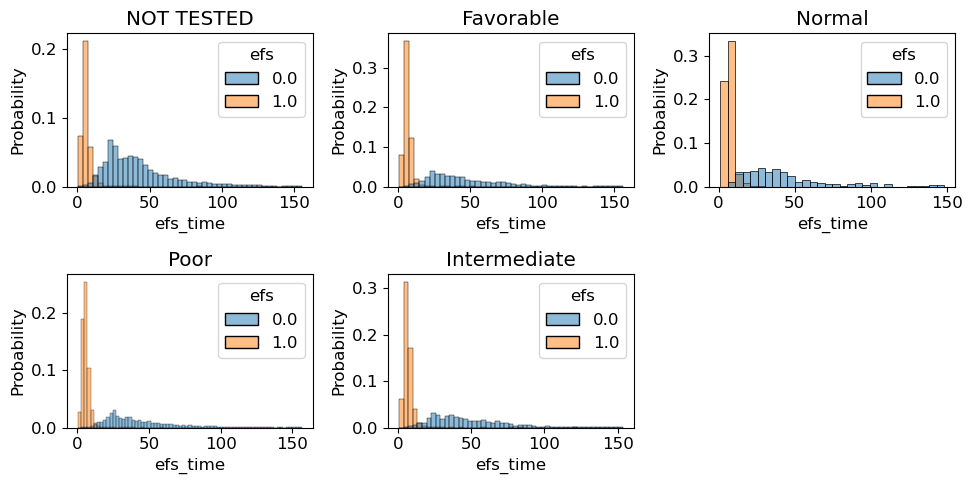

In [113]:
plt.figure(figsize=(10,5))
plt.subplot(2,3,1)
sns.histplot(data=data[data['cyto_score'].str.match('NOT TESTED')], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('NOT TESTED')
plt.subplot(2,3,2)
sns.histplot(data=data[data['cyto_score'] == 'Favorable'], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('Favorable')
plt.subplot(2,3,3)
sns.histplot(data=data[data['cyto_score'].str.match('Normal')], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('Normal')
plt.subplot(2,3,4)
sns.histplot(data=data[data['cyto_score'].str.match('Poor')], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('Poor')
plt.subplot(2,3,5)
sns.histplot(data=data[data['cyto_score'].str.match('Intermediate')], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('Intermediate')
plt.tight_layout()

In [114]:
my_df = {}
my_df['cyto score Not Tested'] = calc_efs_stats(data[data['cyto_score'].str.match('NOT TESTED')])
my_df['cyto score Favorable'] = calc_efs_stats(data[data['cyto_score'].str.match('Favorable')])
my_df['cyto score Normal'] = calc_efs_stats(data[data['cyto_score'].str.match('Normal')])
my_df['cyto score Poor'] = calc_efs_stats(data[data['cyto_score'].str.match('Poor')])
my_df['cyto score Intermediate'] = calc_efs_stats(data[data['cyto_score'].str.match('Intermediate')])
pd.DataFrame.from_dict(my_df, orient='columns')

,cyto score Not Tested,cyto score Favorable,cyto score Normal,cyto score Poor,cyto score Intermediate
Count,8123.00,3011.00,643.00,8802.00,6376.00
Avg efs,0.37,0.60,0.61,0.62,0.60
Sem efs,0.01,0.01,0.02,0.01,0.01
Avg efs_time | efs=0,41.94,44.24,42.61,41.86,47.55
Std efs_time | efs=0,23.75,24.43,28.36,23.58,25.07
Avg efs_time | efs=1,6.12,6.57,6.87,5.81,6.77
Std efs_time | efs=1,3.53,3.16,2.98,2.76,3.85


### Trends by Karnofsky score<a id='trends_by_karnofsky_score'></a>

In [115]:
data['karnofsky_score'].value_counts()

90.0     15336
70.0      6690
100.0     2476
80.0      2036
60.0      1291
50.0        91
40.0        10
Name: karnofsky_score, dtype: int64

In [ ]:
# <50, 50-70, >70 bins are used to broadly quantize patient functional status
# link: https://cibmtr.org/Files/Data-Operations/Retired-Forms-Manuals/Appendices/appendix-l.pdf

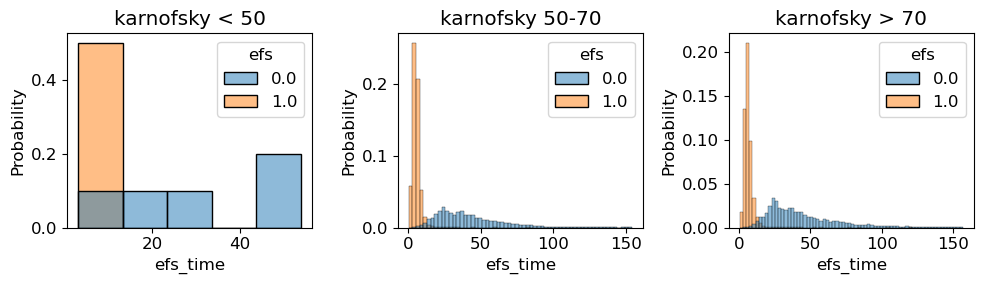

In [120]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
sns.histplot(data=data[data['karnofsky_score'] < 50], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('karnofsky < 50')
plt.subplot(1,3,2)
sns.histplot(data=data[(data['karnofsky_score'] >= 50) & (data['karnofsky_score'] <= 70)], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('karnofsky 50-70')
plt.subplot(1,3,3)
sns.histplot(data=data[data['karnofsky_score'] > 70], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('karnofsky > 70')
plt.tight_layout()

In [122]:
my_df = {}
my_df['karnofsky < 50'] = calc_efs_stats(data[data['karnofsky_score'] < 50])
my_df['karnofsky 50-70'] = calc_efs_stats(data[(data['karnofsky_score'] >= 50) & (data['karnofsky_score'] <= 70)])
my_df['karnofsky > 70'] = calc_efs_stats(data[data['karnofsky_score'] > 70])
pd.DataFrame.from_dict(my_df, orient='columns')

,karnofsky < 50,karnofsky 50-70,karnofsky > 70
Count,10.00,8072.00,19848.00
Avg efs,0.50,0.60,0.52
Sem efs,0.17,0.01,0.00
Avg efs_time | efs=0,30.15,41.22,43.85
Std efs_time | efs=0,21.69,21.96,24.95
Avg efs_time | efs=1,3.29,5.78,6.50
Std efs_time | efs=1,0.34,3.05,3.52


### Trends by CMV status<a id='trends_by_cmv_status'></a>

In [123]:
data['cmv_status'].value_counts()

+/+           13596
-/+            7081
+/-            4048
-/-            3441
NOT TESTED      634
Name: cmv_status, dtype: int64

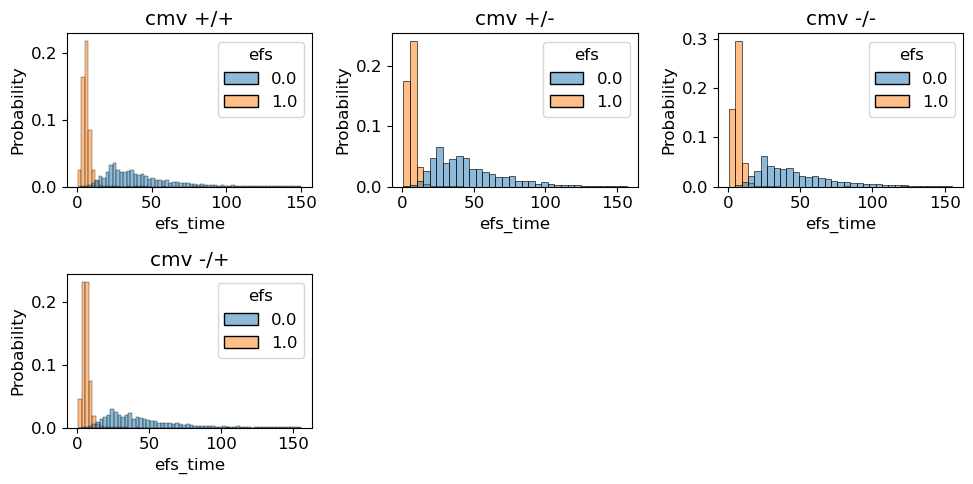

In [124]:
plt.figure(figsize=(10,5))
plt.subplot(2,3,1)
sns.histplot(data=data[data['cmv_status'] == '+/+'], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('cmv +/+')
plt.subplot(2,3,2)
sns.histplot(data=data[data['cmv_status'] == '+/-'], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('cmv +/-')
plt.subplot(2,3,3)
sns.histplot(data=data[data['cmv_status'] == '-/-'], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('cmv -/-')
plt.subplot(2,3,4)
sns.histplot(data=data[data['cmv_status'] == '-/+'], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('cmv -/+')
plt.tight_layout()

In [126]:
my_df = {}
my_df['cmv +/+'] = calc_efs_stats(data[data['cmv_status'] == '+/+'])
my_df['cmv +/-'] = calc_efs_stats(data[data['cmv_status'] == '+/-'])
my_df['cmv -/-'] = calc_efs_stats(data[data['cmv_status'] == '-/-'])
my_df['cmv -/+'] = calc_efs_stats(data[data['cmv_status'] == '-/+'])
pd.DataFrame.from_dict(my_df, orient='columns')

,cmv +/+,cmv +/-,cmv -/-,cmv -/+
Count,13596.00,4048.00,3441.00,7081.00
Avg efs,0.53,0.46,0.52,0.62
Sem efs,0.00,0.01,0.01,0.01
Avg efs_time | efs=0,41.20,46.51,46.82,43.09
Std efs_time | efs=0,23.16,25.06,26.60,24.00
Avg efs_time | efs=1,6.17,6.35,6.55,6.19
Std efs_time | efs=1,3.23,3.00,4.41,3.19


### Trends by Prior Solid Tumor<a id='trends_by_prior_solid_tumor'></a>

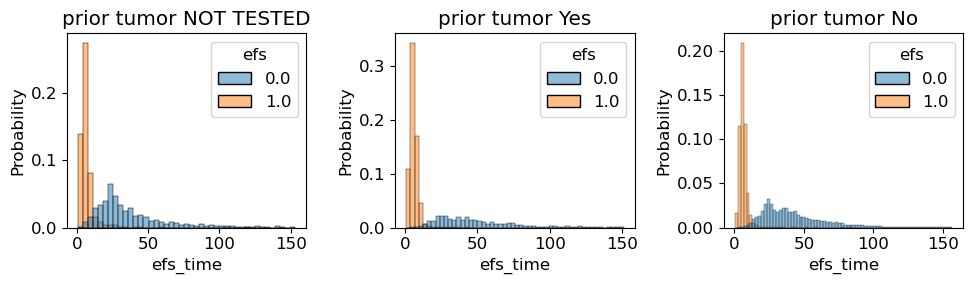

In [132]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
sns.histplot(data=data[data['prior_tumor'] == 'NOT TESTED'], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('prior tumor NOT TESTED')
plt.subplot(1,3,2)
sns.histplot(data=data[data['prior_tumor'] == 'Yes'], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('prior tumor Yes')
plt.subplot(1,3,3)
sns.histplot(data=data[data['prior_tumor'] == 'No'], x='efs_time', hue='efs', stat='probability', common_norm=True)
plt.title('prior tumor No')
plt.tight_layout()

In [133]:
my_df = {}
my_df['prior tumor NOT TESTED'] = calc_efs_stats(data[data['prior_tumor'] == 'NOT TESTED'])
my_df['prior tumor Yes'] = calc_efs_stats(data[data['prior_tumor'] == 'Yes'])
my_df['prior tumor No'] = calc_efs_stats(data[data['prior_tumor'] == 'No'])
pd.DataFrame.from_dict(my_df, orient='columns')

,prior tumor NOT TESTED,prior tumor Yes,prior tumor No
Count,1963.00,3009.00,23828.00
Avg efs,0.53,0.68,0.52
Sem efs,0.01,0.01,0.00
Avg efs_time | efs=0,36.12,47.00,43.35
Std efs_time | efs=0,24.05,26.98,23.92
Avg efs_time | efs=1,6.60,6.17,6.24
Std efs_time | efs=1,6.60,3.03,3.02


## Saving Data<a id='saving_data'></a>

<Axes: >

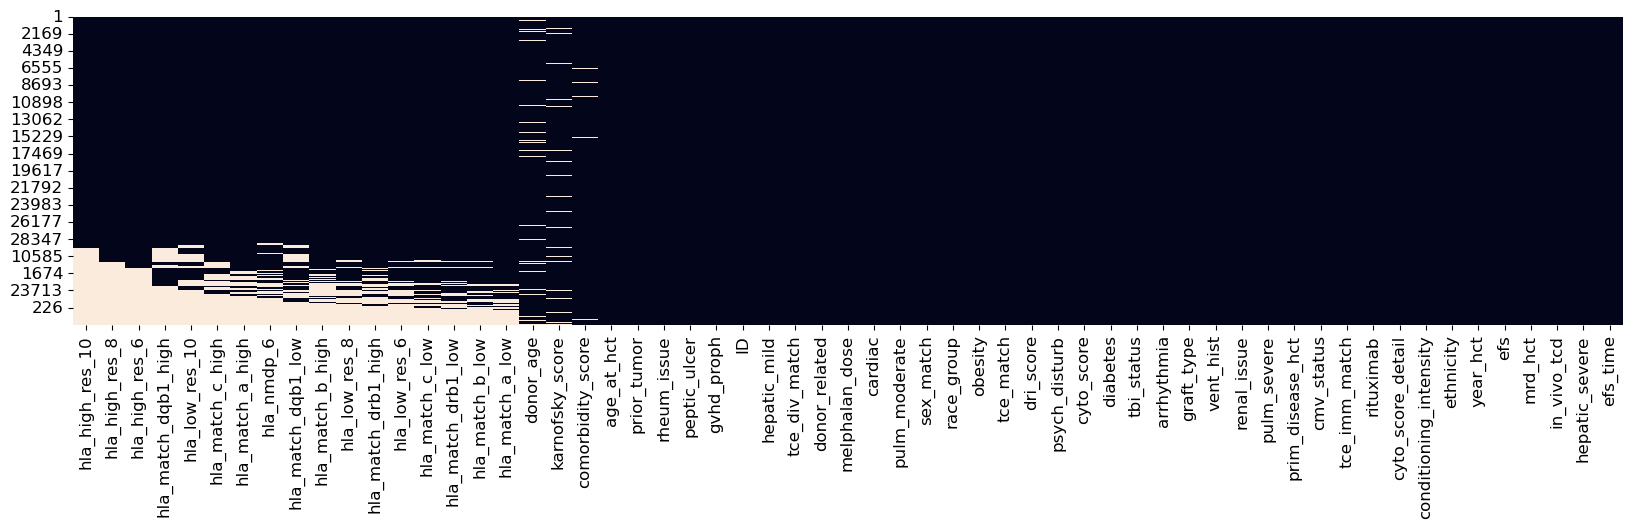

In [36]:
# after filling nans with 'NOT TESTED', replacing 'Not done' with 'NOT TESTED', and dropping prod_type
data = data.drop(columns=['prod_type'])
cols=list(data.notnull().sum().sort_values().index)
plt.figure(figsize=(20,4))
sns.heatmap(data[cols].isnull().sort_values(by=cols[:17]), cbar=False)

In [39]:
data.to_csv('../data/interim/train.csv')

## Summary<a is='summary'></a>
**Results:**
- Converted nans and nan-like values to 'NOT TESTED'
- graft_type and prod_type appear to be redundant, however 5% of values are mismatched. Keeping graft_type and removing prod_type
- Data confirms prognostic factors identified from UpToDate
    - Younger age trends with improved outcomes
        - Consider stratifying age by Infant, Pediatric, Adult (19-40), Adult (41-64), Senior (65+)
    - Increased comorbidities worsens outcome
        - Can stratify by aggregate comorbidity score of [0, 1-2, 3+] or [0,1,2,3,4+]
    - DRI score roughly predicts EFS
    - Cyto score does not predict EFS
    - karnofsky performance score does predict EFS with higher scores leading to improved outcomes. Note: KPS is designed for patients age 16+
    - cmv status does predict EFS with -/+ at most risk and +/- at the least risk
    - prior solid tumor does worsen outcome

### Trends by HLA match

**Result:** t-SNE suggests that there may be some latent patterns within hla data, but not clear whether can help predict efs. Follow-up with additional clustering/embedding models. Consider FFNN to create an embedding of hla data.

Too many columns for hla matching, attempting to reduce data using dimensionality reduction

In [137]:
hla_columns = data.columns[data.columns.str.match('hla')]

In [138]:
data[hla_columns]

,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,hla_match_a_high,hla_match_b_low,hla_match_a_low,hla_match_b_high,hla_low_res_8,hla_match_drb1_high,hla_low_res_10
0,NaN,NaN,6.0,6.0,NaN,2.0,6.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,8.0,2.0,10.0
1,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,8.0,2.0,10.0
2,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,8.0,2.0,10.0
3,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,8.0,2.0,10.0
4,2.0,8.0,6.0,6.0,10.0,2.0,5.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,8.0,2.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,8.0,2.0,10.0
28796,1.0,4.0,5.0,3.0,6.0,2.0,4.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,6.0,1.0,8.0
28797,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,8.0,2.0,10.0
28798,1.0,4.0,3.0,3.0,5.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,5.0


In [139]:
from sklearn.manifold import TSNE

In [146]:
tsne_model = TSNE(perplexity=30, early_exaggeration=4, learning_rate=1000)
xy_tsne = tsne_model.fit_transform(data[hla_columns].dropna())

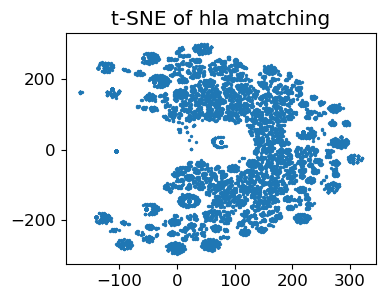

In [148]:
# TSNE(perplexity=30, early_exaggeration=4, learning_rate=1000)
plt.title('t-SNE of hla matching')
plt.scatter(xy_tsne[:,0], xy_tsne[:,1], s=2)

In [151]:
tsne_model.n_iter_

999

899


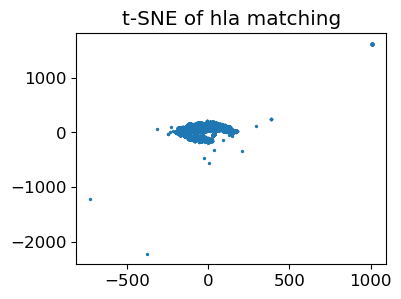

In [ ]:
tsne_model = TSNE(perplexity=50, early_exaggeration=2, learning_rate=5000)
xy_tsne = tsne_model.fit_transform(data[hla_columns].dropna())

plt.title('t-SNE of hla matching')
plt.scatter(xy_tsne[:,0], xy_tsne[:,1], s=2)
print(tsne_model.n_iter_)

(-200.0, 200.0)

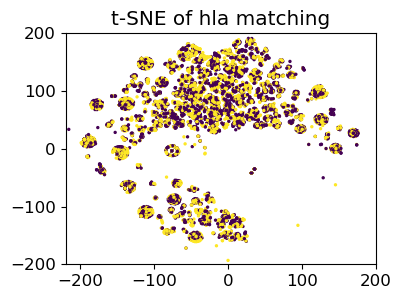

In [245]:
plt.title('t-SNE of hla matching')
plt.scatter(xy_tsne[:,0], xy_tsne[:,1], s=2, c=data[list(hla_columns)+['efs']].dropna()['efs'])
plt.xlim([-220,200])
plt.ylim([-200,200])

999


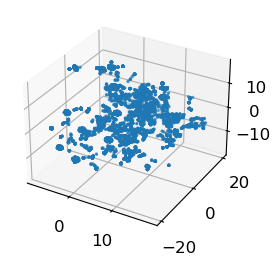

In [167]:
tsne_model = TSNE(n_components=3, perplexity=50, early_exaggeration=1, learning_rate=100)
xy_tsne = tsne_model.fit_transform(data[hla_columns].dropna())
print(tsne_model.n_iter_)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xy_tsne[:,0], xy_tsne[:,1], xy_tsne[:,2], s=2)
plt.show()

In [170]:
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xy_tsne[:5000,0], xy_tsne[:5000,1], xy_tsne[:5000,2], s=2)
plt.show()

<Axes: xlabel='sum', ylabel='Probability'>

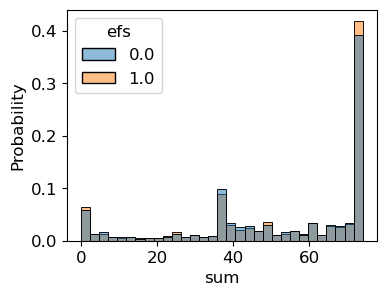

In [241]:
sns.histplot(data=pd.DataFrame({'sum':data[hla_columns].sum(axis=1), 'efs':data['efs']}), x='sum', hue='efs', stat='probability', common_norm=False)

999


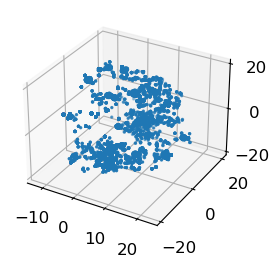

In [183]:
tsne_model = TSNE(n_components=3, perplexity=50, early_exaggeration=1, learning_rate=100)
xy_tsne = tsne_model.fit_transform(((data[hla_columns] - data[hla_columns].mean())/data[hla_columns].std()).dropna())
print(tsne_model.n_iter_)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xy_tsne[:,0], xy_tsne[:,1], xy_tsne[:,2], s=2)
plt.show()

In [184]:
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xy_tsne[:5000,0], xy_tsne[:5000,1], xy_tsne[:5000,2], s=2)
plt.show()

999


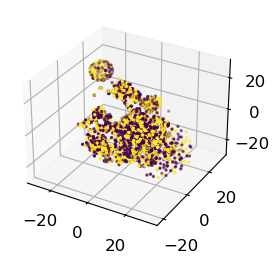

In [207]:
tsne_model = TSNE(n_components=3, perplexity=75, early_exaggeration=1, learning_rate=500, n_iter=5000)
xy_tsne = tsne_model.fit_transform(((data[hla_columns] - data[hla_columns].mean())/data[hla_columns].std()).dropna()[:7250])
c = data[list(hla_columns)+['efs']].dropna()['efs'][:7250]
print(tsne_model.n_iter_)

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xy_tsne[:,0], xy_tsne[:,1], xy_tsne[:,2], s=2, c=c)
plt.show()

In [208]:
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xy_tsne[:,0], xy_tsne[:,1], xy_tsne[:,2], s=2, c=c)
plt.show()

899


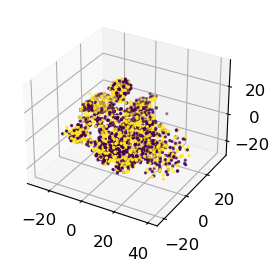

In [209]:
tsne_model = TSNE(n_components=3, perplexity=75, early_exaggeration=1, learning_rate=750, n_iter=5000)
xy_tsne = tsne_model.fit_transform(((data[hla_columns] - data[hla_columns].mean())/data[hla_columns].std()).dropna()[:7250])
c = data[list(hla_columns)+['efs']].dropna()['efs'][:7250]
print(tsne_model.n_iter_)

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xy_tsne[:,0], xy_tsne[:,1], xy_tsne[:,2], s=2, c=c)
plt.show()

In [210]:
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xy_tsne[:,0], xy_tsne[:,1], xy_tsne[:,2], s=2, c=c)
plt.show()

4999


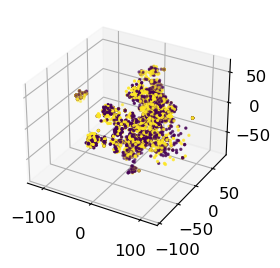

In [226]:
tsne_model = TSNE(n_components=3, perplexity=25, early_exaggeration=1, learning_rate=500, n_iter=5000)
xy_tsne = tsne_model.fit_transform(((data[hla_columns] - data[hla_columns].mean())/data[hla_columns].std()).dropna()[:7250])
c = data[list(hla_columns)+['efs']].dropna()['efs'][:7250]
print(tsne_model.n_iter_)

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xy_tsne[:,0], xy_tsne[:,1], xy_tsne[:,2], s=2, c=c)
plt.show()

In [227]:
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xy_tsne[:,0], xy_tsne[:,1], xy_tsne[:,2], s=2, c=c)
plt.show()